In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

In [5]:
dane = pd.read_csv("data/gym_members_exercise_tracking.csv")

In [7]:
X = sm.add_constant(dane['Session_Duration (hours)'])
y = dane['Calories_Burned']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Calories_Burned   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     4569.
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        11:59:49   Log-Likelihood:                -5989.7
No. Observations:                 973   AIC:                         1.198e+04
Df Residuals:                     971   BIC:                         1.199e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

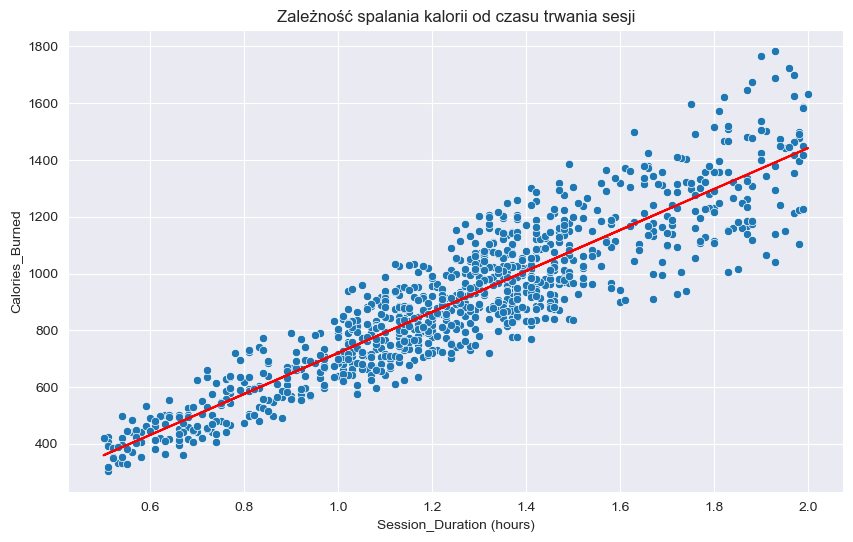

In [11]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Session_Duration (hours)', y='Calories_Burned', data=dane)
plt.plot(dane['Session_Duration (hours)'], model.predict(X), color='red')
plt.title('Zależność spalania kalorii od czasu trwania sesji')
plt.show()

In [12]:
resid = model.resid
print("\nTest normalności reszt (Shapiro-Wilk):")
print(stats.shapiro(resid))


Test normalności reszt (Shapiro-Wilk):
ShapiroResult(statistic=np.float64(0.995224493494818), pvalue=np.float64(0.0038416454231589886))


In [16]:
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

std_resid = influence.resid_studentized_internal
outliers = np.where(np.abs(std_resid) > 3)[0]

n = len(dane)
cutoff = 4/n
influential = np.where(cooks_d > cutoff)[0]

In [17]:
print(f"\nObserwacje odstające: {outliers}")
print(f"Obserwacje wpływowe: {influential}")


Obserwacje odstające: [428 712 910]
Obserwacje wpływowe: [  6  66  70  90  99 124 152 184 212 229 237 276 315 321 367 380 422 428
 430 475 497 511 572 587 591 595 601 646 649 663 692 694 711 712 728 732
 736 738 784 797 801 835 845 848 864 877 896 897 910 948 957 964 970]


In [20]:
dane_clean = dane.drop(influential)
X_clean = sm.add_constant(dane_clean['Session_Duration (hours)'])
y_clean = dane_clean['Calories_Burned']
model_clean = sm.OLS(y_clean, X_clean).fit()
print("\nPodsumowanie modelu po usunięciu wartości wpływowych:")
print(model_clean.summary())


Podsumowanie modelu po usunięciu wartości wpływowych:
                            OLS Regression Results                            
Dep. Variable:        Calories_Burned   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     5004.
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        12:02:02   Log-Likelihood:                -5544.8
No. Observations:                 920   AIC:                         1.109e+04
Df Residuals:                     918   BIC:                         1.110e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for train_index, test_index in kf.split(dane_clean):
    X_train, X_test = X_clean.iloc[train_index], X_clean.iloc[test_index]
    y_train, y_test = y_clean.iloc[train_index], y_clean.iloc[test_index]

    model_cv = sm.OLS(y_train, X_train).fit()

    pred_train = model_cv.predict(X_train)
    pred_test = model_cv.predict(X_test)

    train_r2 = r2_score(y_train, pred_train)
    test_r2 = r2_score(y_test, pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, pred_test))

    results.append({
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    })

In [22]:
results_df = pd.DataFrame(results)
print("\nŚrednie wyniki kroswalidacji:")
print(results_df.mean())



Średnie wyniki kroswalidacji:
train_r2        0.845090
test_r2         0.842449
train_rmse    100.228759
test_rmse     100.788518
dtype: float64


In [23]:
print("\nRóżnica R² między treningiem a testem:",
      results_df['train_r2'].mean() - results_df['test_r2'].mean())


Różnica R² między treningiem a testem: 0.002640707167145706
